In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from tqdm import tqdm
from joblib import Parallel, delayed
from scipy.sparse import csr_matrix
from scipy.optimize import minimize
from numba import njit

# Get the parent directory (go up one level)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Define the path to the library (inside the parent directory)
library_path = os.path.join(parent_dir, "")
# Add to sys.path if not already there
if library_path not in sys.path:
    sys.path.append(library_path)
library_path
import mmars
print(library_path)

c:\Users\rasmu\Documents\GitHub\MMARS\


## Setup a simulation environment

In [2]:
radar_model_1 = mmars.FmcwRadar(position=np.array([[0,0]]),N_chirps=1, signalNoiseRatio=[10,10])
radar_model_1_cpy = radar_model_1

target_model_1 = mmars.Target(start_position=np.array([[10,10]]), start_velocity=1., T_total=15., T_frame=0.1)
target_model_1.generate_trajectory(trajectory_type="sinusoidal")
target_model_1_ground_truth = target_model_1.get_trajectory()

simulation = mmars.Simulation(radar_model_1, target_model_1)
simulation.run()

[[-0.02336045  0.        ]
 [-0.01557363  0.        ]
 [-0.00778682  0.        ]]
[[-0.00292006  0.        ]
 [-0.00097335  0.        ]
 [ 0.00097335  0.        ]
 [ 0.00292006  0.        ]]
Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x0000024C7F1C8D50> and <mmars.target.Target object at 0x0000024C41C589D0>


100%|██████████| 150/150 [00:00<00:00, 979.74it/s]


## Define the MRBLaT algorithm

The MRBLaT algorithm should minimise the Kullback-lieber divergence defined as

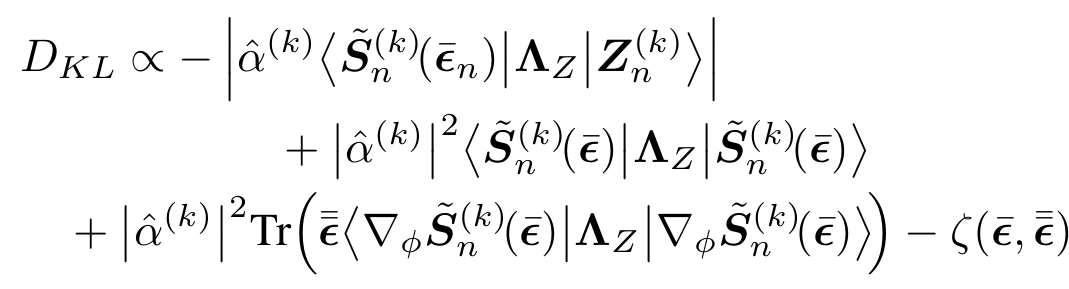


### Defining the loss factor $\alpha$
The loss factor $\alpha$ is defined as 

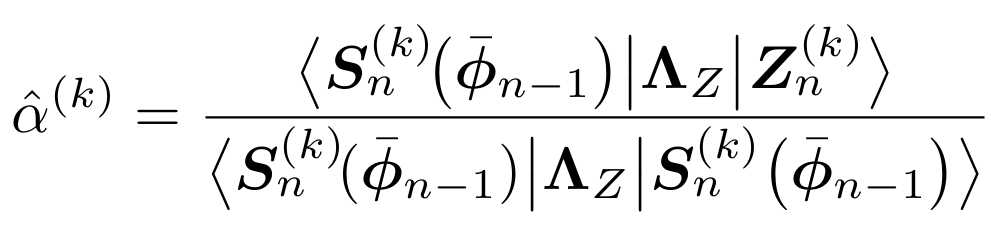

where the previous estimate is used to calculate $\alpha$.

In [3]:
def CALC_LOSS_FACTOR(LAST_POSITION : np.ndarray, LAMBDA_Z : np.ndarray, CURRENT_DATA_FRAME : np.ndarray, RADAR_MODEL_CPY):
    RADAR_MODEL_CPY.generate_S_signal(target_x=LAST_POSITION[0,0], target_y=LAST_POSITION[0,1])
    S_BASED_ON_LAST_POSITION = RADAR_MODEL_CPY.get_S_signal(flatten=True)
    S_BASED_ON_LAST_POSITION_H = S_BASED_ON_LAST_POSITION.conj().T
    return (S_BASED_ON_LAST_POSITION_H @ LAMBDA_Z @ CURRENT_DATA_FRAME) / (S_BASED_ON_LAST_POSITION_H @ LAMBDA_Z @ S_BASED_ON_LAST_POSITION)

### Defining the first term of the $D_{KL}$

The first term of the $D_{KL}$ is defined as

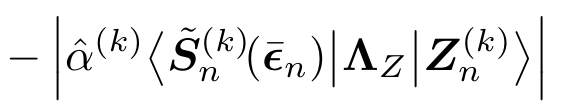

In [4]:
def CALC_FIRST_TERM(LOSS_FACTOR, S_N_H_LAMBDA_Z : np.ndarray, CURRENT_DATA_FRAME : np.ndarray):
    BRAKET = S_N_H_LAMBDA_Z@CURRENT_DATA_FRAME
    return - np.abs(LOSS_FACTOR * BRAKET)

### Defining the second term of the $D_{KL}$

The second term of the $D_{KL}$ is defined as

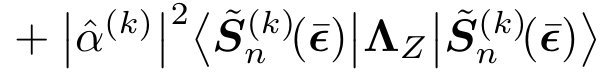

In [5]:
def CALC_SECOND_TERM(LOSS_FACTOR, S_N_H_LAMBDA_Z : np.ndarray, S_N : np.ndarray):
    BRAKET = S_N_H_LAMBDA_Z@S_N
    return np.abs(LOSS_FACTOR)**2 * BRAKET

### Defining the third term of the $D_{KL}$

The third term of the $D_{KL}$ is defined as

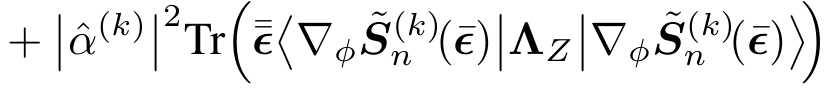

In [6]:
def CALC_THIRD_TERM(LOSS_FACTOR, PARAMS : np.ndarray, LAMBDA_Z : np.ndarray, S_N : np.ndarray):
    JAC = JACOBIAN(PARAMS[0], PARAMS[1])
    JAC_INNER_PRODUCT = JAC.T.conj() @ LAMBDA_Z @ JAC
    COV_MATRIX = np.array([[PARAMS[2], 0], [0, PARAMS[3]]])
    return np.abs(LOSS_FACTOR)**2 * np.trace(COV_MATRIX@JAC_INNER_PRODUCT)

@njit
def MAPLE_PARTIAL_DIFF(x,y, RADAR_ANTENNA_CONFIG,X_R, Y_R,N_SAMPLES,FREQS,CHRIP_RATE,F_SAMPLING,C,WAVELENGTH_C,GAIN,TRANSMIT_POWER,RCS,jjj):
    X_TX = RADAR_ANTENNA_CONFIG[0]
    Y_TX = RADAR_ANTENNA_CONFIG[1]
    X_RX = RADAR_ANTENNA_CONFIG[2]
    Y_RX = RADAR_ANTENNA_CONFIG[3]

    t1 = x - X_R
    t2 = t1 ** 2
    t4 = (y - Y_R) ** 2
    t5 = t2 + t4
    t6 = np.sqrt(t5)
    t8 = 0.1e1 / t6 * CHRIP_RATE
    t9 = 0.1e1 / C
    t10 = 0.1e1 / F_SAMPLING
    t14 = N_SAMPLES + 1
    t18 = t10 * np.pi * t9 * t6 * CHRIP_RATE
    t22 = t14 * (FREQS - 4 * t18) / 2
    t23 = np.cos(t22)
    t27 = FREQS / 2 - 2 * t18
    t28 = np.sin(t27)
    t29 = 0.1e1 / t28
    t34 = np.exp(-jjj * FREQS * N_SAMPLES / 2)
    t36 = x - X_TX
    t37 = t36 ** 2
    t39 = (y - Y_TX) ** 2
    t41 = np.sqrt(t37 + t39)
    t42 = x - X_RX
    t43 = t42 ** 2
    t45 = (y - Y_RX) ** 2
    t47 = np.sqrt(t43 + t45)
    t49 = 0.1e1 / WAVELENGTH_C
    t53 = np.exp(2 * t49 * (t41 + t47) * jjj * np.pi)
    t56 = WAVELENGTH_C ** 2
    t57 = t56 * GAIN * TRANSMIT_POWER
    t60 = t5 ** 2
    t64 = np.sqrt(0.1e1 / t60 / np.pi * RCS * t57)
    t65 = t64 * t53 * t34
    t69 = np.sin(t22)
    t70 = t28 ** 2
    t76 = np.cos(t27)
    t81 = t29 * t69
    t95 = np.pi ** 2
    t108 = -t65 * t29 * t23 * t14 * t1 * t10 * t9 * t8 / 4 + t76 * t1 * t10 * t9 * t8 * t65 / t70 * t69 / 4 + t64 * t53 * t49 * (2 * t36 / t41 + 2 * t42 / t47) * jjj * t34 * t81 / 8 - t1 / t5 / t60 * RCS * t57 / t64 / t95 * t53 * t34 * t81 / 4
    return t108

def BEST_JAC(epsilon,
                        position = np.array([0, 0]),
                        tx_antennas = None, rx_antennas = None,
                        S=30e6/1e-6,T_chirp=25.66e-6, transmitPower=1, gain=1, radarCrossSection=1,
                        f_sampling=20e6, N_samples=256, N_chirps=1, c = 299792458, start_freq = 77e9):
    
    wavelength = c/start_freq
    if tx_antennas is None:
        tx_antennas = np.array(([-12*(wavelength/2), 0],
                                [-8*(wavelength/2), 0],
                                [-4*(wavelength/2), 0]))
    if rx_antennas is None:
        rx_antennas = np.array(([-(3/2)*(wavelength/2), 0],
                                [-(1/2)*(wavelength/2), 0],
                                [(1/2)*(wavelength/2), 0],
                                [(3/2)*(wavelength/2), 0]))
        
    N_vx_antennas = len(tx_antennas) * len(rx_antennas)
    x, y = epsilon
    x_r, y_r = position

    A = np.sqrt(transmitPower * gain * radarCrossSection * wavelength**2 / (4 * np.pi)**3)
    ds = np.arange(0, N_vx_antennas * wavelength/2, wavelength/2) # should be dynamic
    freqs = np.linspace(0, 2 * np.pi, N_samples)[np.newaxis]

    def path_loss(x, y):
        """path loss"""
        r = np.sqrt((x - x_r)**2 + (y - y_r)**2)
        alpha = A/r**2
        return alpha

    def partial_path_loss(x, y, x__R, y__R):
        """path loss alpha partial differentiated w.r.t first entry (works for x/y)"""
        r = np.sqrt((x - x__R)**2 + (y - y__R)**2)
        partial_alpha = - 2 * A * r**(-4) * (x - x__R)
        return partial_alpha

    def steering_matrix(x, y):
        """steering matrix"""
        deltaR = np.sin(-np.atan2(x - x_r, y - y_r)) * ds
        phi = 2 * np.pi * deltaR / wavelength
        steering_mat = np.exp(1.j * 2 * np.pi * phi)
        return steering_mat[:, np.newaxis]

    def partial_steering_matrix(x, y, x__R, y__R, x_partial=True):
        """steering matrix partial differentiated w.r.t x/y"""
        exp1 = 1 + (x - x__R)**2/(y - y__R)**2
        partial_deltaR = (-(1/((y - y__R) * np.sqrt(exp1))) + (x - x__R)**2/((y - y__R)**3 * exp1**(3/2))) * ds
        
        if x_partial == False:
            partial_deltaR = ((x - x__R)/((y - y__R)**2 * np.sqrt(exp1)) - ((x - x__R)**3/((y - y__R)**4 * exp1**(3/2)))) * ds

        partial_phi_deltaR = 2 * np.pi/wavelength

        deltaR = np.sin(-np.atan2(x, y)) * ds
        phi = 2 * np.pi * deltaR / wavelength
        partial_a_phi = 1.j * 2 * np.pi * np.exp(1.j * 2 * np.pi * phi)
        partial_steering_mat = partial_a_phi * partial_phi_deltaR * partial_deltaR
        return partial_steering_mat[:, np.newaxis]
        
    def sinc(x, y):
        """sinc function"""
        r = np.sqrt((x - x_r)**2 + (y - y_r)**2)
        f_IF = 2 * S * r / c * (2 * np.pi / f_sampling)
        K = np.exp(-1.j * freqs * N_samples/2)

        sinc_fnc = K * np.sin((freqs - f_IF) * (N_samples + 1) * 1/2)/np.sin((freqs - f_IF)/2)
        return sinc_fnc
    
    def partial_sinc(x, y, x__R, y__R):
        """sinc fnc (fourier transform of window fnc) partially differentiated w.r.t. first entry"""
        K = np.exp(-1.j * freqs * N_samples/2)
        f = freqs

        # from Maple:
        partial_sinc = (K * S * ((x - x__R) ** 2 + (y - y__R) ** 2) ** (-0.1e1 / 0.2e1) / c * np.pi * (2 * x - 2 * x__R) * (N_samples + 1) 
                        * np.cos((f - S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 5000000) * (N_samples + 1) / 2) 
                        / np.sin(-f / 2 + S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 10000000) / 20000000 + K 
                        * np.sin((f - S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 5000000) * (N_samples + 1) / 2) 
                        / np.sin(-f / 2 + S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 10000000) ** 2 * S 
                        * ((x - x__R) ** 2 + (y - y__R) ** 2) ** (-0.1e1 / 0.2e1) / c * np.pi * (2 * x - 2 * x__R) 
                        * np.cos(-f / 2 + S * np.sqrt((x - x__R) ** 2 + (y - y__R) ** 2) / c * np.pi / 10000000) / 20000000
                        )
        return partial_sinc

    S_tilde = steering_matrix(x, y) @ sinc(x, y)
    partial_S_tilde_x = partial_steering_matrix(x, y, x_r, y_r, x_partial=True) @ sinc(x, y) + steering_matrix(x, y) @ partial_sinc(x, y, x_r, y_r)

    S_jacobian_x = (partial_S_tilde_x * path_loss(x, y) + S_tilde * partial_path_loss(x, y, x_r, y_r)).flatten()[:, np.newaxis]

    partial_S_tilde_y = partial_steering_matrix(x, y, x_r, y_r, x_partial=False) @ sinc(x, y) + steering_matrix(x, y) @ partial_sinc(y, x, y_r, x_r)
    S_jacobian_y = (partial_S_tilde_y * path_loss(x, y) + S_tilde * partial_path_loss(y, x, y_r, x_r)).flatten()[:, np.newaxis]

    S_jacobian = np.hstack((S_jacobian_x, S_jacobian_y))
    return S_jacobian

def JACOBIAN(X, Y, JACBOIAN_SOLVER = "BEST"):    
    N_SAMPLES = radar_model_1.get_N_samples()
    FREQS = np.linspace(0, 2 * np.pi, N_SAMPLES, endpoint=False)
    C = 3e8
    TX_ANTENNAS = radar_model_1.get_tx_antennas()
    RX_ANTENNAS = radar_model_1.get_rx_antennas()

    match JACBOIAN_SOLVER:
        case "MAPLE":
            
            JACOBIAN_RES = np.zeros((len(TX_ANTENNAS) * len(RX_ANTENNAS) * N_SAMPLES, 2), dtype=np.complex128)
            ITTERATION = 0
            for TX in TX_ANTENNAS:
                for RX in RX_ANTENNAS:
                    JACOBIAN_RES[ITTERATION*N_SAMPLES:(ITTERATION+1)*N_SAMPLES, 0] = MAPLE_PARTIAL_DIFF(X, Y, [TX[0], TX[1], RX[0], RX[1]], 
                                                                                                        radar_model_1.get_radar_position()[0,0], radar_model_1.get_radar_position()[0,1], 
                                                                                                        N_SAMPLES, FREQS, radar_model_1.get_chirp_rate(), 
                                                                                                        radar_model_1.get_sampling_frequency(), C, radar_model_1.get_wavelength(), 
                                                                                                        radar_model_1.get_antenna_gain(), radar_model_1.get_transmit_power(), radar_model_1.get_radar_cross_section(), 1j)
                    JACOBIAN_RES[ITTERATION*N_SAMPLES:(ITTERATION+1)*N_SAMPLES, 1] = MAPLE_PARTIAL_DIFF(Y, X, [TX[0], TX[1], RX[0], RX[1]], 
                                                                                                        radar_model_1.get_radar_position()[0,0], radar_model_1.get_radar_position()[0,1], 
                                                                                                        N_SAMPLES, FREQS, radar_model_1.get_chirp_rate(), 
                                                                                                        radar_model_1.get_sampling_frequency(), C, radar_model_1.get_wavelength(), 
                                                                                                        radar_model_1.get_antenna_gain(), radar_model_1.get_transmit_power(), radar_model_1.get_radar_cross_section(), 1j)
                    ITTERATION += 1
            return JACOBIAN_RES
        case "BEST":
            return BEST_JAC((X, Y))
        case _:
            raise ValueError("JACBOIAN_SOLVER not supported. Please use MAPLE.")


### Defining the entropy term of the $D_{KL}$

The entropy term of the $D_{KL}$ is defined as

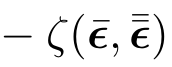

In [7]:
def CALC_ENTROPY(PARAMS : np.ndarray):
    K = 2 # DIMENSION OF THE PROBLEM
    return - K/2 * np.log(2*np.pi*np.e) + 1/2*np.log(PARAMS[2] * PARAMS[3])
    

### Construct the $D_{KL}$ function

In [8]:
LAMBDA_Z = np.eye(3072) * (2.763854534117991e-7)**(-2)
LAMBDA_Z = csr_matrix(LAMBDA_Z)

def D_KL(PARAMS, CURRENT_DATA_FRAME, LAST_POSITION, RADAR_MODEL_CPY):
    #PARAMS[2] = 0.1
    #PARAMS[3] = 0.1
    
    RADAR_MODEL_CPY.generate_S_signal(target_x=PARAMS[0], target_y=PARAMS[1])
    S_N = RADAR_MODEL_CPY.get_S_signal(flatten=True)
    S_N_H_LAMBDA_Z = S_N.conj().T @ LAMBDA_Z

    LOSS_FACTOR = CALC_LOSS_FACTOR(LAST_POSITION, LAMBDA_Z, CURRENT_DATA_FRAME, RADAR_MODEL_CPY)
    # FIRST_TERM = CALC_FIRST_TERM(LOSS_FACTOR, S_N_H_LAMBDA_Z, CURRENT_DATA_FRAME)
    # SECOND_TERM = CALC_SECOND_TERM(LOSS_FACTOR, S_N_H_LAMBDA_Z, S_N)
    # THIRD_TERM = CALC_THIRD_TERM(LOSS_FACTOR, PARAMS, LAMBDA_Z, S_N)
    # ENTROPY = CALC_ENTROPY(PARAMS)
    
    return np.array(np.real(
        LOSS_FACTOR
        # + FIRST_TERM 
        # + SECOND_TERM 
        # + THIRD_TERM 
        # + ENTROPY
    ),dtype=np.float64)

In [9]:
frame = 1
current_frame_fft_data = simulation.get_data(idx=frame,flatten=True,fft_data=True)
bounds = [(-radar_model_1.get_max_range(),radar_model_1.get_max_range()), (1,radar_model_1.get_max_range()), (0.001, 100), (0.001, 100)]
res = minimize(D_KL, (target_model_1_ground_truth[0][frame-1], target_model_1_ground_truth[1][frame-1], 0.1, 0.1), args=(simulation.get_data(idx=frame,flatten=True,fft_data=True), np.array([[target_model_1_ground_truth[0][frame-1], target_model_1_ground_truth[1][frame-1]]]),radar_model_1_cpy), bounds=bounds, method="Nelder-Mead")#, options={'xatol': 1e-8, 'disp': False})
print(f"Estimated position: {res.x[0:2]} \nTrue position: {target_model_1_ground_truth[0][frame], target_model_1_ground_truth[1][frame]}")

Estimated position: [10. 10.] 
True position: (np.float64(10.099998333341667), np.float64(10.1))


## Visualise the performance of the MRBLaT algorithm

### Plot the data, estimated data and jacobian

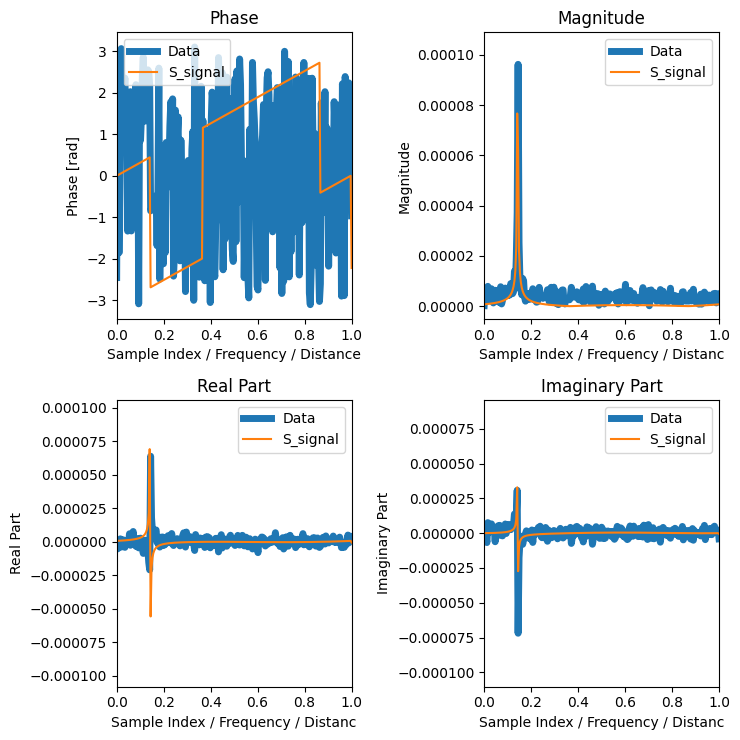

In [10]:
NS = radar_model_1.get_N_samples()*len(radar_model_1.get_rx_antennas())*len(radar_model_1.get_tx_antennas())
indecies = np.linspace(0, len(radar_model_1.get_rx_antennas())*len(radar_model_1.get_tx_antennas()), NS)
radar_model_1_cpy.generate_S_signal(target_x=target_model_1_ground_truth[0][frame], target_y=target_model_1_ground_truth[1][frame])

fig, ax = plt.subplots(2,2, figsize=(7.5, 7.5))
ax[0,0].plot(indecies, np.angle(current_frame_fft_data), label="Data", lw=5)
ax[0,0].plot(indecies, np.angle(radar_model_1_cpy.get_S_signal(flatten=True)), label="S_signal")
ax[0,0].set_title("Phase")
ax[0,0].set_xlabel("Sample Index / Frequency / Distance")
ax[0,0].set_ylabel("Phase [rad]")
ax[0,0].legend()

ax[0,1].plot(indecies, np.abs(current_frame_fft_data), label="Data", lw=5)
ax[0,1].plot(indecies, np.abs(radar_model_1_cpy.get_S_signal(flatten=True)), label="S_signal")
ax[0,1].set_title("Magnitude")
ax[0,1].set_xlabel("Sample Index / Frequency / Distanc")
ax[0,1].set_ylabel("Magnitude")
ax[0,1].legend()

ax[1,0].plot(indecies, np.real(current_frame_fft_data), label="Data", lw=5)
ax[1,0].plot(indecies, np.real(radar_model_1_cpy.get_S_signal(flatten=True)), label="S_signal")
ax[1,0].set_title("Real Part")
ax[1,0].set_xlabel("Sample Index / Frequency / Distanc")
ax[1,0].set_ylabel("Real Part")
ax[1,0].legend()

ax[1,1].plot(indecies, np.imag(current_frame_fft_data), label="Data", lw=5)
ax[1,1].plot(indecies, np.imag(radar_model_1_cpy.get_S_signal(flatten=True)), label="S_signal")
ax[1,1].set_title("Imaginary Part")
ax[1,1].set_xlabel("Sample Index / Frequency / Distanc")
ax[1,1].set_ylabel("Imaginary Part")
ax[1,1].legend()

for ax_idx_1 in range(ax.shape[0]):
    for ax_idx_2 in range(ax.shape[1]):
        ax[ax_idx_1, ax_idx_2].set_xlim(0, 1)
plt.tight_layout()

### 2D heat maps

In [11]:
heatmap_resolution = 50
location_x_axis = np.flip(np.linspace(50, 0, heatmap_resolution*2+1, dtype=np.float64))
location_y_axis = np.flip(np.linspace(50, 0, heatmap_resolution,endpoint=False, dtype=np.float64))
heatmap_location = np.zeros((heatmap_resolution, heatmap_resolution), dtype=np.float64)

variance_x_axis = np.flip(np.linspace(10, 0, heatmap_resolution,endpoint=False))
variance_y_axis = np.flip(np.linspace(10, 0, heatmap_resolution,endpoint=False))
heatmap_variance = np.zeros((heatmap_resolution, heatmap_resolution), dtype=np.float64)

for i in tqdm(range(heatmap_resolution)):
    for j in range(heatmap_resolution):
        heatmap_location[i,j] = D_KL([location_x_axis[i], location_y_axis[j], .1, .1], current_frame_fft_data[:,np.newaxis], np.array([[target_model_1_ground_truth[0][frame-1], target_model_1_ground_truth[1][frame-1]]]), radar_model_1_cpy)
        heatmap_variance[i,j] = D_KL([target_model_1_ground_truth[0][frame], target_model_1_ground_truth[1][frame], variance_x_axis[i], variance_y_axis[j]], current_frame_fft_data[:,np.newaxis], np.array([[target_model_1_ground_truth[0][frame-1], target_model_1_ground_truth[1][frame-1]]]), radar_model_1_cpy)

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\rasmu\AppData\Local\Temp\ipykernel_23504\2805326734.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  heatmap_location[i,j] = D_KL([location_x_axis[i], location_y_axis[j], .1, .1], current_frame_fft_data[:,np.newaxis], np.array([[target_model_1_ground_truth[0][frame-1], target_model_1_ground_truth[1][frame-1]]]), radar_model_1_cpy)
C:\Users\rasmu\AppData\Local\Temp\ipykernel_23504\2805326734.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  heatmap_variance[i,j] = D_KL([target_model_1_ground_truth[0][frame], target_model_1_ground_truth[1][frame], variance_x_axis[i], variance_y_axis[j]],

#### 2D heat map of location estimate

Lowest D_KL: -0.1134160822778536 at (0.0, 1.0)
True Position: (10.099998333341667, 10.1)


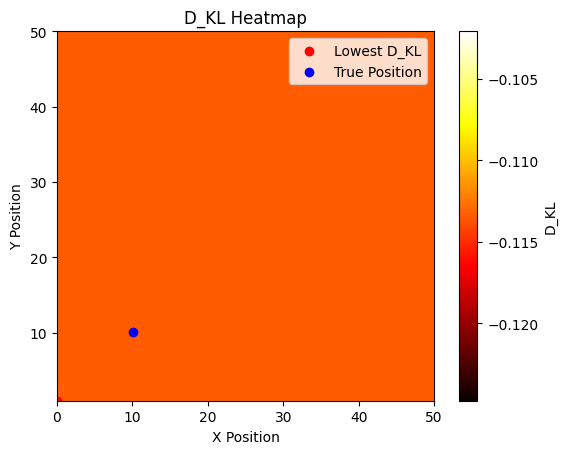

In [12]:
plt.imshow((((heatmap_location))), extent=(-location_x_axis[0], location_x_axis[-1], location_y_axis[0], location_y_axis[-1]), origin='lower', cmap='hot')#,vmin=-6, vmax=4
plt.colorbar(label='D_KL')
min_value = np.min(heatmap_location)
min_index = np.unravel_index(np.argmin(heatmap_location), heatmap_location.shape)
min_x = location_x_axis[min_index[0]]
min_y = location_y_axis[min_index[1]]
plt.scatter(min_x, min_y, color='red', label='Lowest D_KL')
print(f"Lowest D_KL: {min_value} at ({min_x}, {min_y})")
plt.scatter(target_model_1_ground_truth[0][frame], target_model_1_ground_truth[1][frame], color='blue', label='True Position')
print(f"True Position: ({target_model_1_ground_truth[0][frame]}, {target_model_1_ground_truth[1][frame]})")
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('D_KL Heatmap')
plt.legend()
plt.show()

#### 2D heat map of estimation variances

Lowest D_KL: -0.1134160822778536 at (0.1999999999999993, 0.1999999999999993)


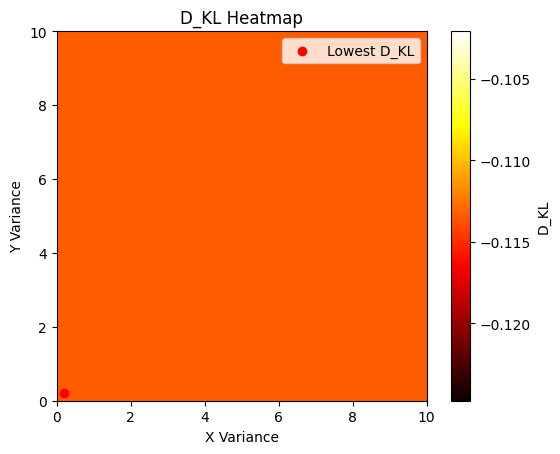

In [13]:
plt.imshow((heatmap_variance), extent=(0, 10, 0, 10), origin='lower', cmap='hot')
plt.colorbar(label='D_KL')
min_value = np.min(heatmap_variance)
min_index = np.unravel_index(np.argmin(heatmap_variance), heatmap_variance.shape)
min_x = variance_x_axis[min_index[0]]
min_y = variance_y_axis[min_index[1]]
plt.scatter(min_x, min_y, color='red', label='Lowest D_KL')
print(f"Lowest D_KL: {min_value} at ({min_x}, {min_y})")
plt.xlabel('X Variance')
plt.ylabel('Y Variance')
plt.title('D_KL Heatmap')
plt.legend()
plt.show()


## Run MRBLaT

In [14]:
# Cycle through the frames and solve the optimization problem for each frame 
results = np.zeros((simulation.get_number_of_frames(), 4), dtype=np.float64)
results[0,:] = np.array([target_model_1_ground_truth[0][0], target_model_1_ground_truth[1][0], .1, .1])
dkl_res = np.zeros((simulation.get_number_of_frames(), 1), dtype=np.float64)
print(results[0,:])
bounds = [(-radar_model_1.get_max_range(),radar_model_1.get_max_range()), (1,radar_model_1.get_max_range()), (0.001, 100), (0.001, 100)]
for frame_idx in tqdm(range(1, simulation.get_number_of_frames())):
    res = minimize(D_KL, (results[frame_idx-1,0], results[frame_idx-1,1], results[frame_idx-1,2], results[frame_idx-1,3]), args=(simulation.get_data(idx=frame_idx,flatten=True,fft_data=True), np.array([[results[frame_idx-1,0], results[frame_idx-1,1]]]),radar_model_1_cpy), bounds=bounds, method="Nelder-Mead", options={'xatol': 1e-8, 'disp': False})
    results[frame_idx,:] = res.x
    dkl_res[frame_idx] = D_KL(res.x, simulation.get_data(idx=frame_idx,flatten=True,fft_data=True), np.array([[results[frame_idx-1,0], results[frame_idx-1,1]]]), radar_model_1_cpy)


[10.  10.   0.1  0.1]


100%|██████████| 149/149 [00:42<00:00,  3.49it/s]


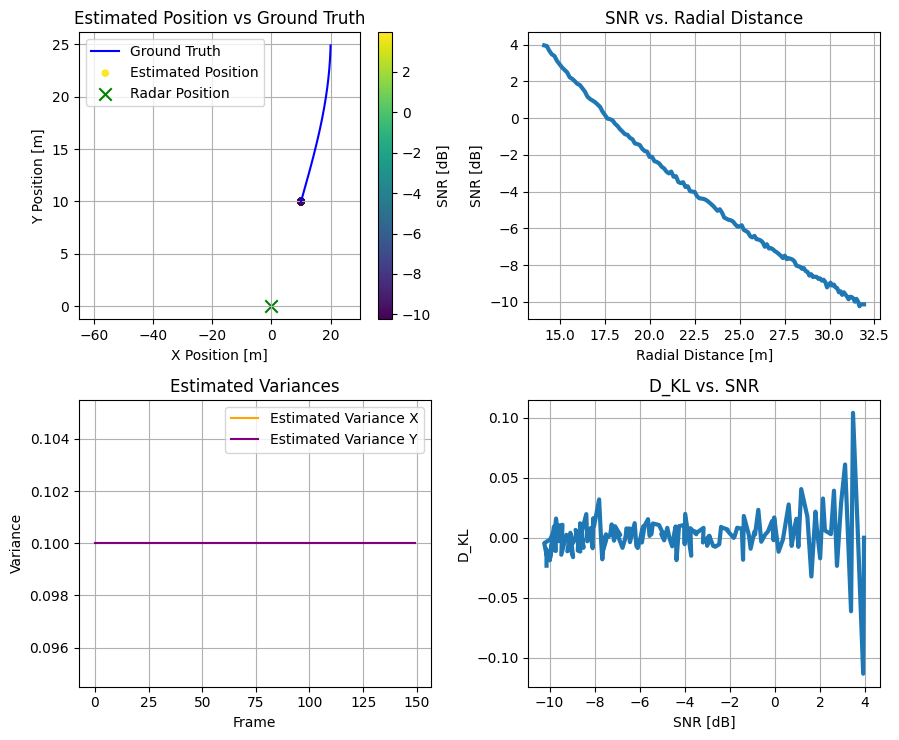

In [15]:
fig, ax = plt.subplots(2,2, figsize=(9, 7.5))

# Position estimates vs ground truth
ax[0,0].plot(target_model_1_ground_truth[0], target_model_1_ground_truth[1], label="Ground Truth", color="blue")
ax[0,0].scatter(results[:,0], results[:,1], c=simulation.get_SNR(), cmap='viridis', label="Estimated Position", s=20)
ax[0,0].scatter(radar_model_1.get_radar_position()[0,0], radar_model_1.get_radar_position()[0,1], color="green", label="Radar Position", s=80, marker="x")
ax[0,0].set_xlabel("X Position [m]")
ax[0,0].set_ylabel("Y Position [m]")
ax[0,0].set_title("Estimated Position vs Ground Truth")
ax[0,0].legend()
ax[0,0].grid()
ax[0,0].set_xlim(-65, 30)
sc = ax[0,0].scatter(results[:,0], results[:,1], c=simulation.get_SNR(), cmap='viridis', label="Estimated Position", s=20)
cbar = fig.colorbar(sc, ax=ax[0,0])
cbar.set_label("SNR [dB]")  # Label the colorbar


# Plot SNR vs. radial distance
ax[0,1].plot(np.linalg.norm(np.array([target_model_1_ground_truth[0], target_model_1_ground_truth[1]]), axis=0), simulation.get_SNR(),lw=3)
ax[0,1].set_xlabel("Radial Distance [m]")
ax[0,1].set_ylabel("SNR [dB]")
ax[0,1].set_title("SNR vs. Radial Distance")
ax[0,1].grid()

# Plot estimated variances
ax[1,0].plot(results[:,2], label="Estimated Variance X", color="orange")
ax[1,0].plot(results[:,3], label="Estimated Variance Y", color="purple")
ax[1,0].set_xlabel("Frame")
ax[1,0].set_ylabel("Variance")
ax[1,0].set_title("Estimated Variances")
ax[1,0].legend()
ax[1,0].grid()

# Plot D_KL values vs. SNR
ax[1,1].plot(simulation.get_SNR(), dkl_res, lw=3)
ax[1,1].set_xlabel("SNR [dB]")
ax[1,1].set_ylabel("D_KL")
ax[1,1].set_title("D_KL vs. SNR")
ax[1,1].grid()


plt.tight_layout()
plt.show()